In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/label_encoded_telecom_data.csv')

In [3]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the specified columns
df[['TotalCharges', 'MonthlyCharges', 'tenure']] = scaler.fit_transform(df[['TotalCharges', 'MonthlyCharges', 'tenure']])

# Display the first few rows to verify the scaling
print(df[['TotalCharges', 'MonthlyCharges', 'tenure']].head())

   TotalCharges  MonthlyCharges    tenure
0     -0.994194       -1.161694 -1.280248
1     -0.173740       -0.260878  0.064303
2     -0.959649       -0.363923 -1.239504
3     -0.195248       -0.747850  0.512486
4     -0.940457        0.196178 -1.239504


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Split the data into training and testing sets
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine X_train and y_train for resampling
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data.Churn == 0]
minority_class = train_data[train_data.Churn == 1]

# Downsample majority class
majority_downsampled = resample(majority_class, 
                                replace=False,    # sample without replacement
                                n_samples=len(minority_class), # to match minority class
                                random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
downsampled_train_data = pd.concat([majority_downsampled, minority_class])

# Separate features and target variable
X_train_downsampled = downsampled_train_data.drop('Churn', axis=1)
y_train_downsampled = downsampled_train_data['Churn']

In [5]:
X_train_downsampled = X_train_downsampled.drop('customerID', axis=1)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

f1_scorer = make_scorer(f1_score, average='weighted')


In [7]:
from sklearn.tree import DecisionTreeClassifier


# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'max_features': [1, 2, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Define the scorer

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring=f1_scorer, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_downsampled, y_train_downsampled)

# Get the best estimator
best_dt = grid_search.best_estimator_

# Predict on the test set
y_pred = best_dt.predict(X_test.drop('customerID', axis=1))

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Best parameters found: {grid_search.best_params_}")
print(f"F1 score on test set: {f1}")

Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
F1 score on test set: 0.7233655645348328


In [8]:
print(f"Best train score found: {grid_search.best_score_}")

Best train score found: 0.7363961261669916


In [9]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring=f1_scorer, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search_rf.fit(X_train_downsampled, y_train_downsampled)

# Get the best estimator
best_rf = grid_search_rf.best_estimator_

# Predict on the test set
y_pred_rf = best_rf.predict(X_test.drop('customerID', axis=1))

# Calculate the F1 score
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Best parameters found for Random Forest: {grid_search_rf.best_params_}")
print(f"F1 score on test set for Random Forest: {f1_rf}")
print(f"Best train score found for Random Forest: {grid_search_rf.best_score_}")

Best parameters found for Random Forest: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
F1 score on test set for Random Forest: 0.7490395806921274
Best train score found for Random Forest: 0.7606106226234057


In [10]:
from sklearn.svm import SVC

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Initialize the SVM classifier
svm = SVC(random_state=42)

# Initialize the GridSearchCV object for SVM
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, scoring=f1_scorer, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search_svm.fit(X_train_downsampled, y_train_downsampled)

# Get the best estimator
best_svm = grid_search_svm.best_estimator_

# Predict on the test set
y_pred_svm = best_svm.predict(X_test.drop('customerID', axis=1))

# Calculate the F1 score
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print(f"Best parameters found for SVM: {grid_search_svm.best_params_}")
print(f"F1 score on test set for SVM: {f1_svm}")
print(f"Classification report for SVM: {grid_search_svm.best_score_}")

Best parameters found for SVM: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
F1 score on test set for SVM: 0.7240449146843363
Classification report for SVM: 0.7501661599449219


In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 600],
    'max_depth': [9, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Initialize the GridSearchCV object for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, scoring=f1_scorer, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search_xgb.fit(X_train_downsampled, y_train_downsampled)

# Get the best estimator
best_xgb = grid_search_xgb.best_estimator_

# Predict on the test set
y_pred_xgb = best_xgb.predict(X_test.drop('customerID', axis=1))

# Calculate the F1 score
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"Best parameters found for XGBoost: {grid_search_xgb.best_params_}")
print(f"F1 score on test set for XGBoost: {f1_xgb}")
print(f"Best train score found for XGBoost: {grid_search_xgb.best_score_}")

Best parameters found for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'subsample': 0.6}
F1 score on test set for XGBoost: 0.7436570515916903
Best train score found for XGBoost: 0.7569674824272549


In [12]:
classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
classifier_xgb.fit(X_train_downsampled, y_train_downsampled)
print(f"Best train score found for XGBoost: {classifier_xgb.score(X_train_downsampled, y_train_downsampled)}")
print(f"Best test score found for XGBoost: {classifier_xgb.score(X_test.drop('customerID', axis=1), y_test)}")

Best train score found for XGBoost: 0.7926421404682275
Best test score found for XGBoost: 0.7185501066098081


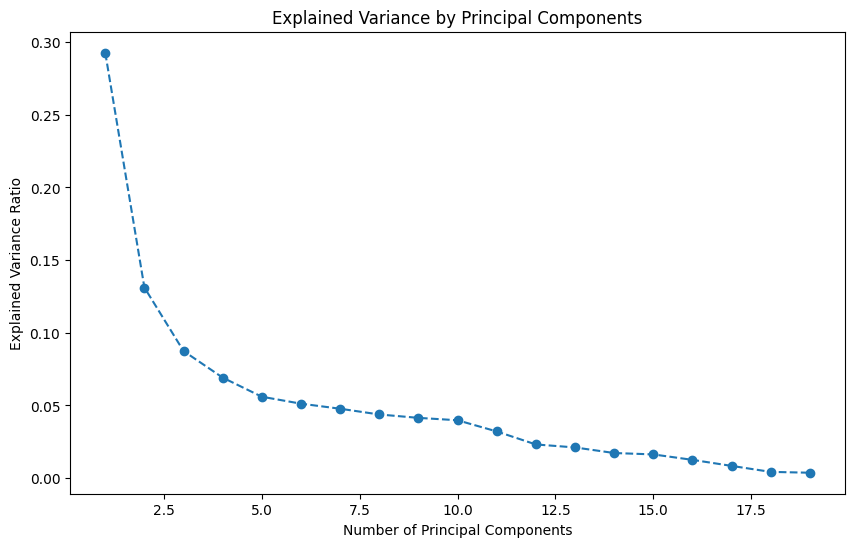

In [13]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Initialize PCA
pca = PCA()

# Fit PCA on the training data
pca.fit(X_train_downsampled)

# Plot the explained variances
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Determine the number of components that explain 80% of the variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
k = (cumulative_variance < 0.90).sum() + 1

# Transform the training and test data using the selected number of principal components
X_train_pca = pca.transform(X_train_downsampled)[:, :k]
X_test_pca = pca.transform(X_test.drop('customerID', axis=1))[:, :k]

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'max_features': [1, 2, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV object
grid_search_pca = GridSearchCV(estimator=dt, param_grid=param_grid, scoring=f1_scorer, cv=5, n_jobs=-1)

# Fit the grid search to the PCA-transformed data
grid_search_pca.fit(X_train_pca, y_train_downsampled)

# Get the best estimator
best_dt_pca = grid_search_pca.best_estimator_

# Predict on the test set
y_pred_pca = best_dt_pca.predict(X_test_pca)

# Calculate the F1 score
f1_pca = f1_score(y_test, y_pred_pca, average='weighted')

print(f"Number of principal components: {k}")
print(f"Best parameters found: {grid_search_pca.best_params_}")
print(f"F1 score on test set: {f1_pca}")
print(f"Best train score found: {grid_search_pca.best_score_}")

Number of principal components: 12
Best parameters found: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
F1 score on test set: 0.7174630396956485
Best train score found: 0.7135606496833524


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Initialize the Logistic Regression classifier
lr = LogisticRegression(random_state=42)
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 300]
}

# Initialize the GridSearchCV object for Logistic Regression
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, scoring=f1_scorer, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search_lr.fit(X_train_downsampled, y_train_downsampled)

# Get the best estimator
best_lr = grid_search_lr.best_estimator_

# Predict on the test set
y_pred_lr = best_lr.predict(X_test.drop('customerID', axis=1))

# Calculate the F1 score
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"Best parameters found for Logistic Regression: {grid_search_lr.best_params_}")
print(f"F1 score on test set for Logistic Regression: {f1_lr}")
print(f"Best train score found for Logistic Regression: {grid_search_lr.best_score_}")


Best parameters found for Logistic Regression: {'C': 100, 'max_iter': 100}
F1 score on test set for Logistic Regression: 0.7401734979318377
Best train score found for Logistic Regression: 0.7645999916723402


In [16]:
lr_elastic  = LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.7)
lr_elastic.fit(X_train_downsampled, y_train_downsampled)
y_pred_lr_elastic = lr_elastic.predict(X_test.drop('customerID', axis=1))
f1_lr_elastic = f1_score(y_test, y_pred_lr_elastic, average='weighted')
print(f"F1 score on test set for Elastic Net Logistic Regression: {f1_lr_elastic}")
print(f"Best test score found for Logistic Regression: {best_xgb.score(X_train_downsampled, y_train_downsampled)}")

F1 score on test set for Elastic Net Logistic Regression: 0.7408230774525374
Best test score found for Logistic Regression: 0.8675585284280937


In [17]:
import torch
import torch.nn as nn

class DynamicNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers_config, activation_function=nn.ReLU):
        """
        input_size: int, the size of the input features
        output_size: int, the number of output classes
        hidden_layers_config: list of int, where each int represents the number of neurons in that layer
        activation_function: nn.Module, the activation function class (e.g., nn.ReLU, nn.Tanh)
        """
        super(DynamicNN, self).__init__()
        layers = []

        # Construct the hidden layers with the chosen activation function
        current_size = input_size
        for num_neurons in hidden_layers_config:
            layers.append(nn.Linear(current_size, num_neurons))
            layers.append(activation_function())  # Add the chosen activation function
            current_size = num_neurons

        # Add the final output layer (without activation)
        layers.append(nn.Linear(current_size, output_size))

        # Combine layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [18]:
def GetDevice():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = GetDevice()
print(device)

cpu


/home/prajas/anaconda3/envs/cuda_env/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim

class PyTorchModel(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, output_size, hidden_layers_config=[64, 32], activation_function=nn.ReLU, lr=0.001, epochs=10, batch_size=32):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers_config = hidden_layers_config
        self.activation_function = activation_function
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.classes_ = None
        self.model = DynamicNN(input_size, output_size, hidden_layers_config, activation_function).to(device)
        
    def fit(self, X, y):
        X_tensor = torch.FloatTensor(X).to(device)
        y_tensor = torch.LongTensor(y).to(device)
        
        self.classes_ = torch.unique(y_tensor).cpu().numpy()  
        
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        self.model.train()
        for epoch in range(self.epochs):
            for inputs, targets in dataloader:

                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad() #Setting gradient to zero after every iteration
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        return self

    def score(self, X, y):

        X_tensor = torch.FloatTensor(X).to(device)
        y_tensor = torch.LongTensor(y).to(device)
        self.model.eval()
        with torch.no_grad(): # To ensure gradients are not calculated
            
            outputs = self.model(X_tensor)
            _, predictions = torch.max(outputs, 1)
            accuracy = (predictions == y_tensor).sum().item() / len(y_tensor)
        return accuracy
    
    def predict(self, X):
        X_tensor = torch.FloatTensor(X).to(device)
        self.model.eval()
        with torch.no_grad(): # To ensure gradients are not calculated
            
            outputs = self.model(X_tensor)
            _, predictions = torch.max(outputs, 1)

        return predictions.cpu().numpy()



In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for PyTorchModel
param_grid_pytorch = {
    'hidden_layers_config': [[30, 30], [64, 32], [128, 64, 32], [256, 128, 64], [128, 128, 128]],
    'activation_function': [nn.ReLU, nn.Tanh, nn.Sigmoid],
    'lr': [0.001, 0.01, 0.1],
    'epochs': [10, 12, 15],
    'batch_size': [128, 256, 512]
}

# Initialize the PyTorchModel
pytorch_model = PyTorchModel(input_size=X_train_downsampled.shape[1], output_size=len(y_train_downsampled.unique()))

# Initialize the GridSearchCV object for PyTorchModel
grid_search_pytorch = GridSearchCV(estimator=pytorch_model, param_grid=param_grid_pytorch, scoring=f1_scorer, cv=5, n_jobs=-1)

X_train_downsampled_np = X_train_downsampled.to_numpy() 
y_train_downsampled_np = y_train_downsampled.to_numpy()

# Fit the grid search to the data
grid_search_pytorch.fit(X_train_downsampled_np, y_train_downsampled_np)

# Get the best estimator
best_pytorch_model = grid_search_pytorch.best_estimator_


/home/prajas/anaconda3/envs/cuda_env/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/prajas/anaconda3/envs/cuda_env/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/prajas/anaconda3/envs/cuda_env/lib/python3

In [43]:

# Predict on the test set
y_pred_pytorch = best_pytorch_model.predict(X_test.drop(['customerID', 'Cluster'], axis=1).to_numpy())

# Calculate the F1 score
f1_pytorch = f1_score(y_test, y_pred_pytorch)

print(f"Best parameters found for PyTorchModel: {grid_search_pytorch.best_params_}")
print(f"F1 score on test set for PyTorchModel: {f1_pytorch}")
print(f"Best train score found for PyTorchModel: {grid_search_pytorch.best_score_}")

Best parameters found for PyTorchModel: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 128, 'epochs': 10, 'hidden_layers_config': [64, 32], 'lr': 0.001}
F1 score on test set for PyTorchModel: 0.6140155728587319
Best train score found for PyTorchModel: 0.761785955542436


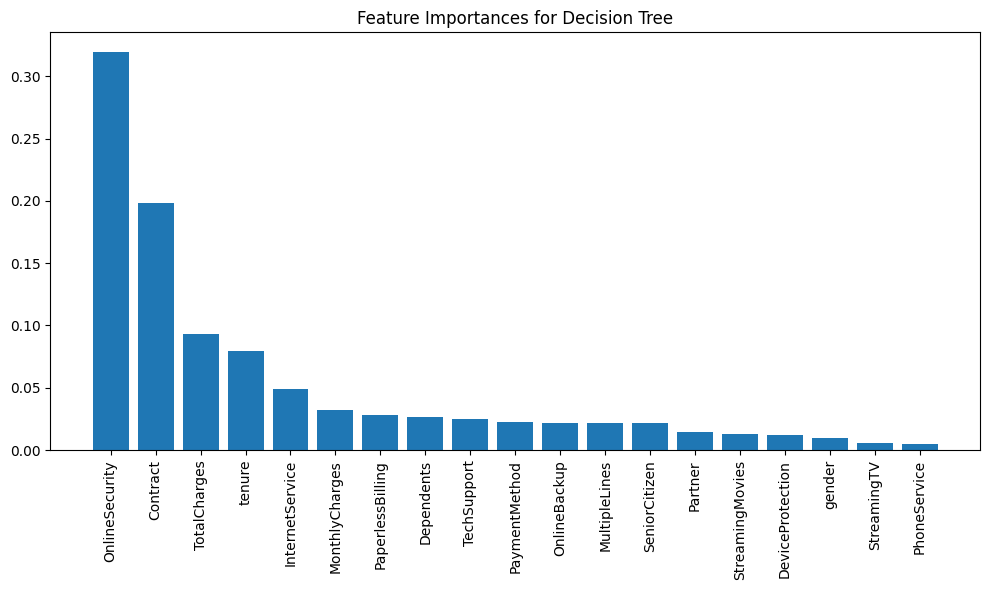

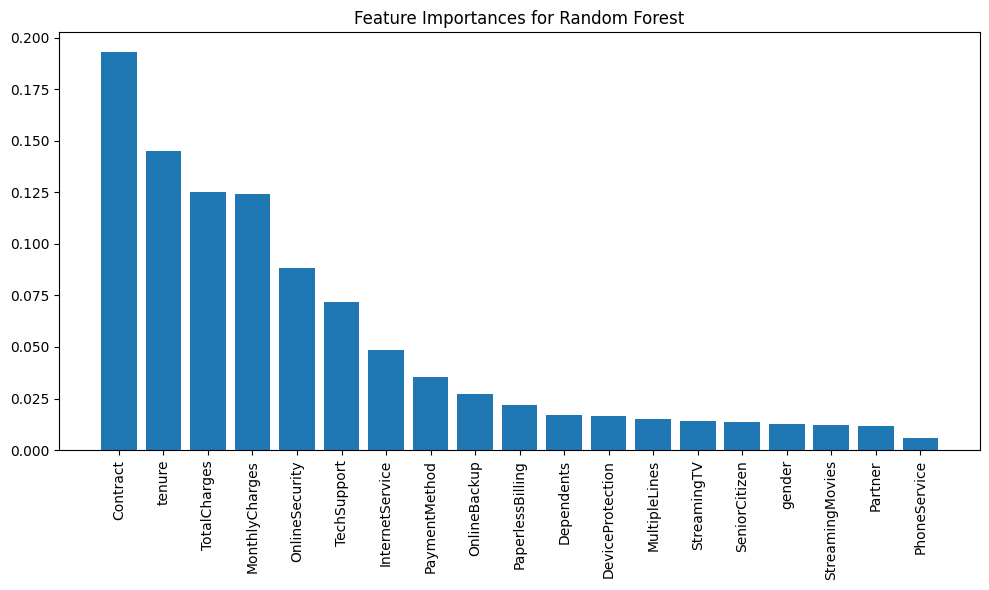

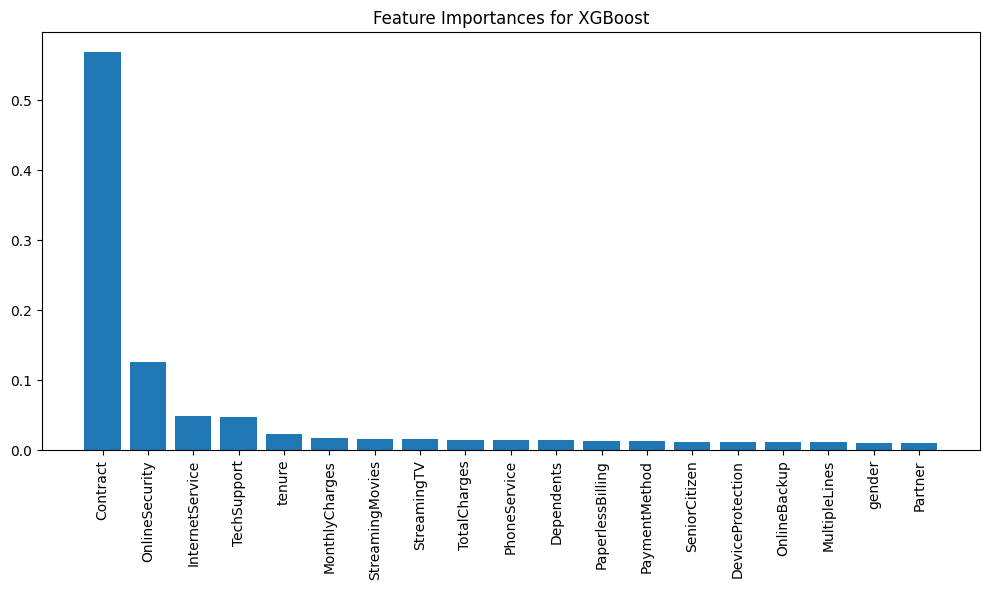

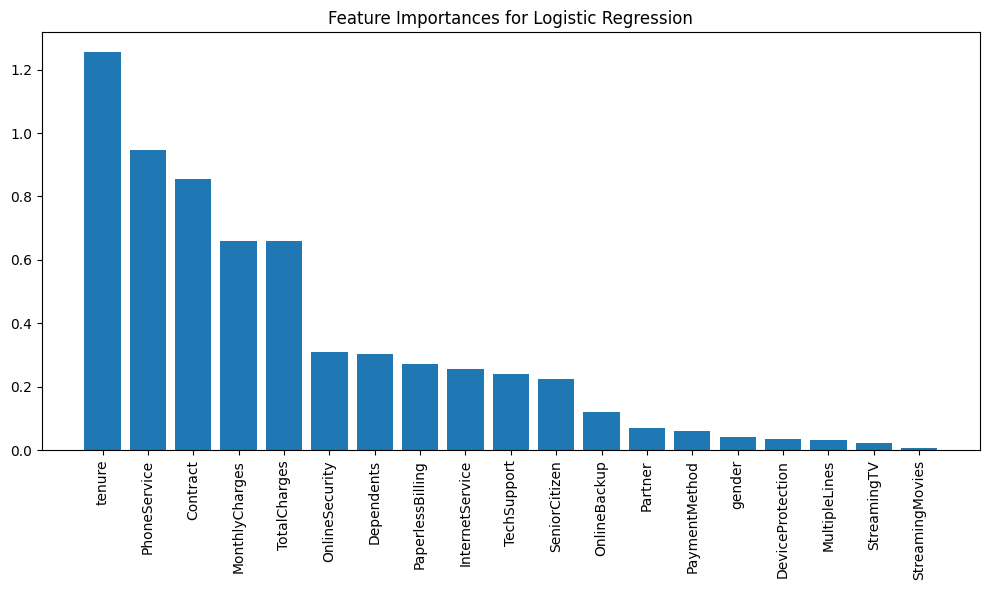

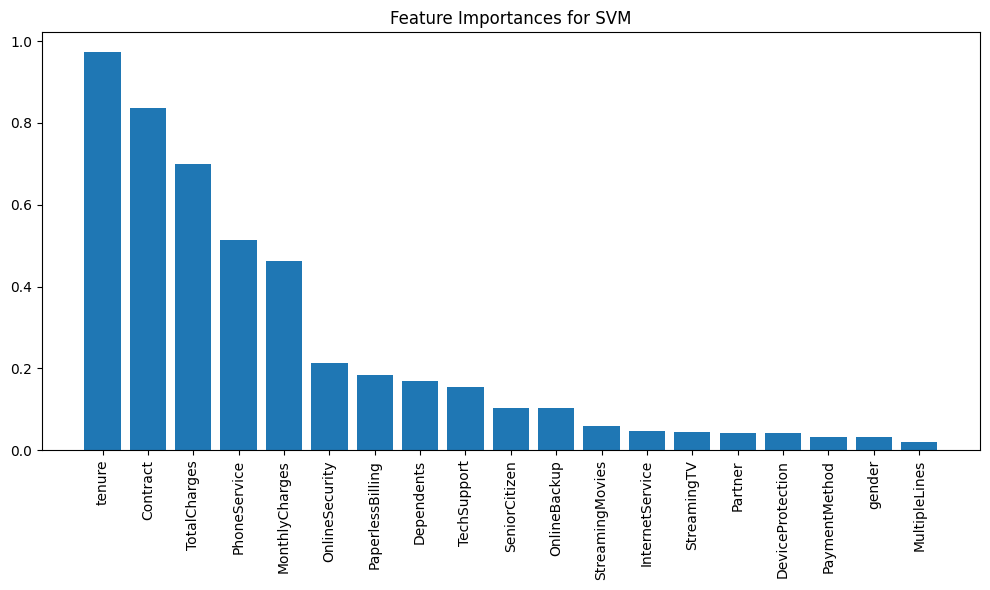

Model PyTorch Model does not support feature importances.


In [22]:
import numpy as np

import matplotlib.pyplot as plt

def plot_feature_importances(model, model_name, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print(f"Model {model_name} does not support feature importances.")
        return
    
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for {model_name}")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Feature names
feature_names = X_train_downsampled.columns

# Plot feature importances for each model
plot_feature_importances(best_dt, "Decision Tree", feature_names)
plot_feature_importances(best_rf, "Random Forest", feature_names)
plot_feature_importances(best_xgb, "XGBoost", feature_names)
plot_feature_importances(best_lr, "Logistic Regression", feature_names)
plot_feature_importances(best_svm, "SVM", feature_names)
plot_feature_importances(best_pytorch_model.model, "PyTorch Model", feature_names)

In [23]:
rf = RandomForestClassifier()

rf.fit(X_train_downsampled, y_train_downsampled)


RandomForestClassifier()

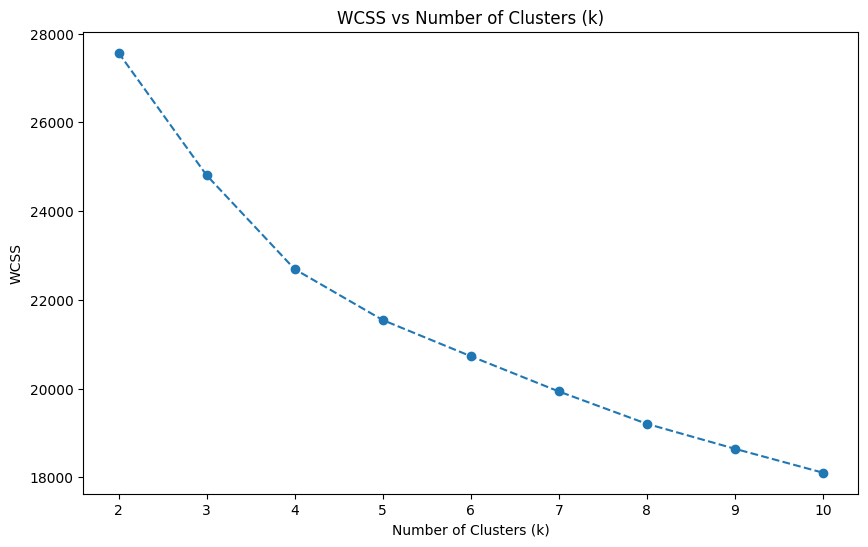

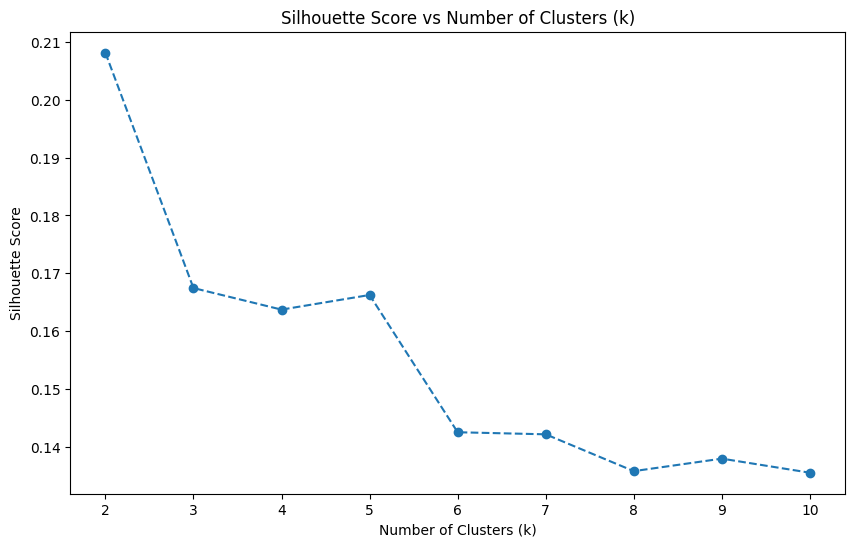

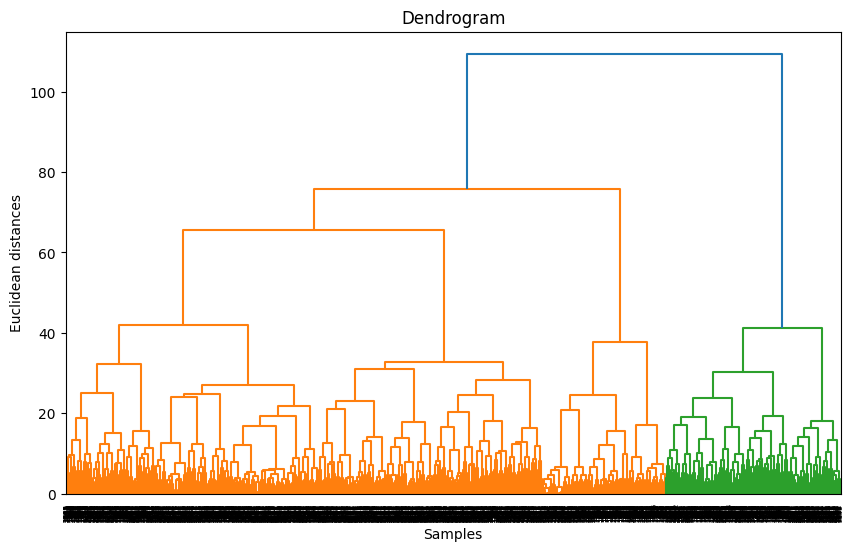

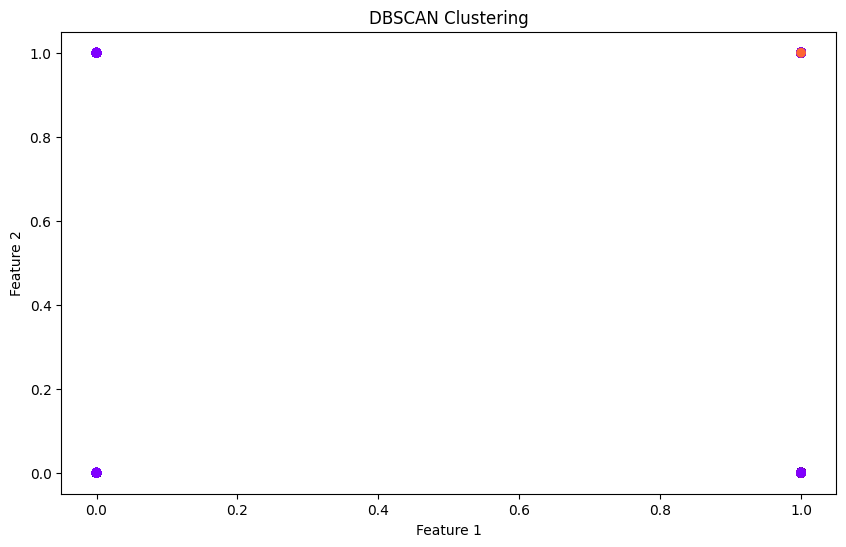

Silhouette Score for DBSCAN: -0.2345975695515545


In [35]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Perform K-means clustering
wcss = []
silhouette_scores_kmeans = []
for i in range(2, 11):  # Silhouette score is not defined for a single cluster
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_train_downsampled)
    wcss.append(kmeans.inertia_)
    silhouette_scores_kmeans.append(silhouette_score(X_train_downsampled, kmeans.labels_))

# Plot WCSS vs k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), [None] + wcss, marker='o', linestyle='--')  # None for k=1
plt.title('WCSS vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Plot Silhouette Score vs k
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores_kmeans, marker='o', linestyle='--')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# Perform hierarchical clustering
linked = linkage(X_train_downsampled, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_train_downsampled)

# Calculate silhouette score for DBSCAN
silhouette_score_dbscan = silhouette_score(X_train_downsampled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Plot DBSCAN clustering results
plt.figure(figsize=(10, 6))
plt.scatter(X_train_downsampled.iloc[:, 0], X_train_downsampled.iloc[:, 1], c=dbscan_labels, cmap='rainbow')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

print(f"Silhouette Score for DBSCAN: {silhouette_score_dbscan}")

In [29]:
f1_score(y_train_downsampled, rf.predict(X_train_downsampled))

0.9983283182881979

/home/prajas/anaconda3/envs/cuda_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



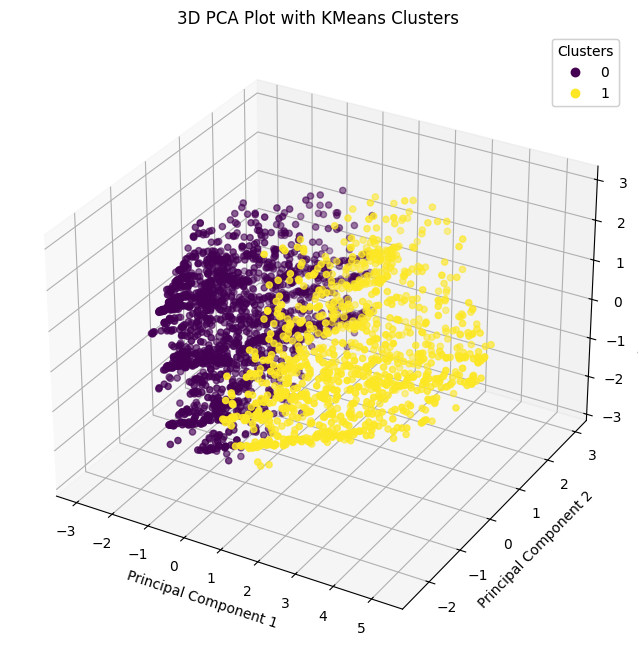

In [54]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Fit KMeans with 4 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42)
kmeans_2_labels = kmeans_2.fit_predict(X_train_downsampled)

# Fit PCA with 3 components
pca_3 = PCA(n_components=3)
X_train_pca_3 = pca_3.fit_transform(X_train_downsampled)

# Plot the data in 3D with the principal components as the axes and the cluster labels as the color
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca_3[:, 0], X_train_pca_3[:, 1], X_train_pca_3[:, 2], c=kmeans_2_labels, cmap='viridis')

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Plot with KMeans Clusters')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()
import plotly.express as px

# Create a DataFrame for the PCA components and cluster labels
pca_df = pd.DataFrame(X_train_pca_3, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = kmeans_2_labels

# Create an interactive 3D plot with reduced marker size
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster', title='3D PCA Plot with KMeans Clusters')
fig.update_traces(marker=dict(size=3))  # Reduce marker size
fig.show()

In [55]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score for the KMeans clusters
silhouette_avg = silhouette_score(X_train_downsampled, kmeans_2_labels)
print(f"Silhouette Score for KMeans clusters: {silhouette_avg}")

Silhouette Score for KMeans clusters: 0.20814088213632245


In [57]:
f1_scorer_binary = make_scorer(f1_score, average='binary', pos_label=1)


In [58]:
# Add KMeans clustering labels to the training and testing data

X_train_downsampled_kmeans = X_train_downsampled.copy()
X_test_kmeans = X_test.copy()

X_train_downsampled_kmeans['Cluster'] = kmeans_2_labels
X_test_kmeans['Cluster'] = kmeans_2.predict(X_test.drop('customerID', axis=1))

# Define the parameter grid for Decision Tree
param_grid_dt_with_cluster = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'max_features': [1, 2, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree classifier
dt_with_cluster = DecisionTreeClassifier(random_state=42)

# Initialize the GridSearchCV object
grid_search_dt_with_cluster = GridSearchCV(estimator=dt_with_cluster, param_grid=param_grid_dt_with_cluster, scoring=f1_scorer_binary, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search_dt_with_cluster.fit(X_train_downsampled_kmeans, y_train_downsampled)

# Get the best estimator
best_dt_with_cluster = grid_search_dt_with_cluster.best_estimator_

# Predict on the test set
y_pred_with_cluster = best_dt_with_cluster.predict(X_test_kmeans.drop('customerID', axis=1))

# Calculate the F1 score
f1_with_cluster = f1_score(y_test, y_pred_with_cluster, average='binary', pos_label=1)

print(f"Best parameters found: {grid_search_dt_with_cluster.best_params_}")
print(f"F1 score on test set: {f1_with_cluster}")

Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
F1 score on test set: 0.5708245243128963


In [62]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred_dt = best_dt.predict(X_test.drop('customerID', axis=1))

# Print the classification report
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.89      0.69      0.78      1033
           1       0.47      0.76      0.58       374

    accuracy                           0.71      1407
   macro avg       0.68      0.72      0.68      1407
weighted avg       0.78      0.71      0.72      1407

